# Optimization with Transaction costs (Solution)

In this lesson, we’ll show you how to incorporate transaction costs into portfolio optimization.  This will give your backtest a more realistic measure of your alpha’s performance.  In addition, we’ll show you some additional ways to design your optimization with efficiency in mind.  This is really helpful when  backtesting, because having reasonably shorter runtimes allows you to test and iterate on your alphas more quickly.

In [1]:
import sys
!{sys.executable} -m pip install -r requirements.txt

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import gzip
import bz2
from statsmodels.formula.api import ols
from scipy.stats import gaussian_kde
import scipy
import scipy.sparse
import patsy
from statistics import median
import datetime

## Barra data

We’ll be using factor data that is generated by Barra.  This will be good practice because Barra data is used throughout the industry.  

Note that we've pre-processed the raw barra data files and stored the data into pickle files. The alternative would be to load the original data, and perform the parsing each time.  Since parsing and pre-processing takes time, we recommend doing the pre-processing once and saving the pre-processed data for later use in your backtest.

Choose the number of years to use for the backtest.  The data is available for years 2003 to 2008 inclusive.

In [3]:
barra_dir = '../../data/project_8_barra/'

In [4]:
!ls {barra_dir}

covariance.2003.pickle	pandas-frames.2003.pickle  price.2003.pickle
covariance.2004.pickle	pandas-frames.2004.pickle  price.2004.pickle
covariance.2005.pickle	pandas-frames.2005.pickle  price.2005.pickle
covariance.2006.pickle	pandas-frames.2006.pickle  price.2006.pickle
covariance.2007.pickle	pandas-frames.2007.pickle  price.2007.pickle
covariance.2008.pickle	pandas-frames.2008.pickle  price.2008.pickle


In [5]:
data = {}
for year in [2003]:
    fil = barra_dir + "pandas-frames." + str(year) + ".pickle"
    data.update(pickle.load( open( fil, "rb" ) ))
    
covariance = {}
for year in [2003]:
    fil = barra_dir + "covariance." + str(year) + ".pickle"
    covariance.update(pickle.load( open(fil, "rb" ) ))
    
daily_return = {}
for year in [2003, 2004]:
    fil = barra_dir + "price." + str(year) + ".pickle"
    daily_return.update(pickle.load( open(fil, "rb" ) ))

Notice that the frames variale is a dictionary, where the keys are strings representing each business day.

## View the Barra data

We'll take a look at the value stored for a single day (it's a data frame).

As a general reminder of best practices, remember to check what unit of measure your data is in. In some cases, the unit of measure isn’t available in the documentation, so you’ll want to inspect the data to see what makes sense.

For instance, there are volatility fields that are large enough that we can assume they are in percentage units, as opposed to decimal values.  In other cases, when we look at daily volume, we may not have documentation about whether the units are in number of shares or in dollars. One way to find this out is to spot check a single stock on a single day, and cross-reference with another source, such as Bloomberg or Yahoo Finance.
Remember to inspect the data before you use it, as it will help you derive more meaningful results in your portfolio optimization, and in your backtest.

Remember to inspect the data before you use it, as it will help you derive more meaningful results in your portfolio optimization, and in your backtest.

In the exercise, we'll re-scale the data before using it, and there will be comments to point out when we re-scale the data.  So don't worry about adjusting anything here, just take a look to get familiar with the data.

In [6]:
data.keys()

dict_keys(['20030102', '20030103', '20030106', '20030107', '20030108', '20030109', '20030110', '20030113', '20030114', '20030115', '20030116', '20030117', '20030121', '20030122', '20030123', '20030124', '20030127', '20030128', '20030129', '20030130', '20030131', '20030203', '20030204', '20030205', '20030206', '20030207', '20030210', '20030211', '20030212', '20030213', '20030214', '20030218', '20030219', '20030220', '20030221', '20030224', '20030225', '20030226', '20030227', '20030228', '20030303', '20030304', '20030305', '20030306', '20030307', '20030310', '20030311', '20030312', '20030313', '20030314', '20030317', '20030318', '20030319', '20030320', '20030321', '20030324', '20030325', '20030326', '20030327', '20030328', '20030331', '20030401', '20030402', '20030403', '20030404', '20030407', '20030408', '20030409', '20030410', '20030411', '20030414', '20030415', '20030416', '20030417', '20030421', '20030422', '20030423', '20030424', '20030425', '20030428', '20030429', '20030430', '2003

In [7]:
data['20030102'].head()

,Barrid,USFASTD_1DREVRSL,USFASTD_AERODEF,USFASTD_AIRLINES,USFASTD_ALUMSTEL,USFASTD_APPAREL,USFASTD_AUTO,USFASTD_BANKS,USFASTD_BETA,USFASTD_BEVTOB,...,BidAskSpread,DailyVolume,ADTCA_30,IssuerMarketCap,Yield,TotalRisk,SpecRisk,HistBeta,PredBeta,DataDate
0,USA0001,-0.837,0.000,0.0,0.000,0.0,0.0,0.0,-2.329,0.0,...,NaN,NaN,NaN,3.441677e+10,0.292740,22.940188,16.825603,-0.000285,0.194528,20030102
1,USA0011,-0.530,0.000,0.0,0.000,0.0,0.0,0.0,-2.329,0.0,...,NaN,NaN,NaN,1.758417e+09,0.000000,35.056218,26.040331,0.000025,0.150303,20030102
2,USA0031,0.109,0.000,0.0,0.000,0.0,0.0,0.0,-2.018,0.0,...,NaN,2900.0,NaN,6.256875e+10,2.350000,25.585521,18.842191,0.133644,0.364634,20030102
3,USA0062,-0.259,0.434,0.0,0.000,0.0,0.0,0.0,-2.378,0.0,...,NaN,NaN,NaN,2.046586e+10,3.125000,34.361884,30.552489,-0.021132,0.274658,20030102
4,USA0071,-0.394,0.000,0.0,0.665,0.0,0.0,0.0,-2.332,0.0,...,NaN,NaN,NaN,1.988087e+10,2.633889,22.893482,15.466688,-0.001328,0.246267,20030102


In [8]:
data['20030102'].shape

(12252, 92)

#### Factors

Note that the data fields that start with the prefix U-S-F-A-S-T are factor exposures, one column for each factor.  We will use some of these as alpha factors, and the rest as risk factors.  The reason this makes sense is that, for the time periods in which we’re back-testing, some of these factors were able to produce better than average returns.  Barra works with its clients (funds) and gathers information about alphas that worked in the past.  These were calculated on historical data to produce the factor exposure data found in the Barra data.

![alt text](./images_optimization/barra_field_factor_exposure.png)

## Factors

Here's a partial list of the barra factors in our dataset and their definitions.  These are collected from documentation by Barra.  There are style factors and industry factors.  The industry factors will be used as risk factors.  You can consider using the style factors as alpha factors.  Any factors not used as alpha factors can be included in the risk factors category.

#### Style factors
* beta: Describes market risk that cannot be explained by the Country factor. The Beta factor is typically the most important style factor. We calculate Beta by time-series regression of stock excess returns against the market return.
* 1 day reversal
* dividend yield: Describes differences in stock returns attributable to stock's historical and predicted dividend-to-price ratios.
* downside risk (maximum drawdown)
* earnings quality:  Describes stock return differences due to the accrual components of earnings.
* earnings yield: Describes return differences based on a company’s earnings relative to its price. Earnings Yield is considered by many investors to be a strong value signal. The most important descriptor in this factor is the analyst-predicted 12-month earnings-to-price ratio.
* growth: Differentiates stocks based on their prospects for sales or earnings growth. The most important descriptor in this factor is the analyst predicted long-term earnings growth. Other descriptors include sales and earnings growth over the previous five years.
* leverage: Describes return differences between high and low-leverage stocks. The descriptors within this style factor include market leverage, book leverage, and debt-to-assets ratio.
* liquidity: Describes return differences due to relative trading activity. The descriptors for this factor are based on the fraction of total shares outstanding that trade over a recent window.
* long-term reversal: Describes common variation in returns related to a long-term (five years ex. recent thirteen months) stock price behavior.
* management quality
* Mid capitalization: Describes non-linearity in the payoff to the Size factor across the market-cap spectrum. This factor is based on a single raw descriptor: the cube of the Size exposure. However, because this raw descriptor is highly collinear with the Size factor, it is orthogonalized with respect to Size. This procedure does not affect the fit of the model, but does mitigate the confounding effects of collinearity, while preserving an intuitive meaning for the Size factor. As described by Menchero (2010), the Mid Capitalization factor roughly captures the risk of a “barbell portfolio” that is long mid-cap stocks and short small-cap and large-cap stocks.
* Momentum – Differentiates stocks based on their performance over the trailing 12 months. When computing Momentum exposures, we exclude the most recent returns in order to avoid the effects of short-term reversal. The Momentum factor is often the second strongest factor in the model, although sometimes it may surpass Beta in importance.
* Profitability – Combines profitability measures that characterize efficiency of a firm's operations and total activities.
* Residual Volatility – Measures the idiosyncratic volatility anomaly. It has three descriptors: (a) the volatility of daily excess returns, (b) the volatility of daily residual returns, and (c) the cumulative range of the stock over the last 12 months. Since these descriptors tend to be highly collinear with the Beta factor, the Residual Volatility factor is orthogonalized with respect to the Beta and Size factors.
* seasonality
* sentiment
* Size – Represents a strong source of equity return covariance, and captures return differences between large-cap and small-cap stocks. We measure Size by the log of market capitalization.
* Short term reversal
* Value
* Prospect -- is a function of skewness and maximum drawdown.
* Management Quality -- is a function of the following: 
    * Asset Growth: Annual reported company assets are regressed against time over the past five fiscal years. The slope coefficient is then divided by the average annual assets to obtain the asset growth.
    * Issuance Growth Annual reported company number of shares outstanding regressed against time over the past five fiscal years. The slope coefficient is then divided by the average annual number of shares outstanding.
    * Capital Expenditure Growth: Annual reported company capital expenditures are regressed against time over the past five fiscal years. The slope coefficient is then divided by the average annual capital expenditures to obtain the capital expenditures growth.
    * Capital Expenditure: The most recent capital expenditures are scaled by the average of capital expenditures over the last five fiscal years.



#### Industry Factors
* aerospace and defense
* airlines
* aluminum and steel
* apparel
* Automotive
* banks
* beta (market)
* beverage and tobacco
* biotech & life science
* building products
* chemicals
* construction & engineering
* construction & machinery
* construction materials
* commercial equipment
* computer & electronics
* commercial services
* industrial conglomerates
* containers (forest, paper, & packaging)
* distributors
* diversified financials
* electrical equipment
* electrical utility
* food & household products & personal
* food & staples retailing
* gas & multi-utilities
* healthcare equipment and services
* health services
* home building
* household durables
* industry machinery
* non-life insurance
* leisure products
* leisure services
* life insurance
* managed healthcare
* multi-utilities
* oil & gas conversion
* oil & gas drilling
* oil & gas equipment
* oil and gas export
* paper
* pharmaceuticals
* precious metals
* personal products
* real estate
* restaurants
* road & rail
* semiconductors
* semiconductors equipment
* software
* telecommunications
* transportation
* wireless
* SPTY\* and SPLTY\* are various industries

In [9]:
data['20030102'].columns

Index(['Barrid', 'USFASTD_1DREVRSL', 'USFASTD_AERODEF', 'USFASTD_AIRLINES',
       'USFASTD_ALUMSTEL', 'USFASTD_APPAREL', 'USFASTD_AUTO', 'USFASTD_BANKS',
       'USFASTD_BETA', 'USFASTD_BEVTOB', 'USFASTD_BIOLIFE', 'USFASTD_BLDGPROD',
       'USFASTD_CHEM', 'USFASTD_CNSTENG', 'USFASTD_CNSTMACH',
       'USFASTD_CNSTMATL', 'USFASTD_COMMEQP', 'USFASTD_COMPELEC',
       'USFASTD_COMSVCS', 'USFASTD_CONGLOM', 'USFASTD_CONTAINR',
       'USFASTD_DISTRIB', 'USFASTD_DIVFIN', 'USFASTD_DIVYILD',
       'USFASTD_DWNRISK', 'USFASTD_EARNQLTY', 'USFASTD_EARNYILD',
       'USFASTD_ELECEQP', 'USFASTD_ELECUTIL', 'USFASTD_FOODPROD',
       'USFASTD_FOODRET', 'USFASTD_GASUTIL', 'USFASTD_GROWTH',
       'USFASTD_HLTHEQP', 'USFASTD_HLTHSVCS', 'USFASTD_HOMEBLDG',
       'USFASTD_HOUSEDUR', 'USFASTD_INDMACH', 'USFASTD_INDMOM',
       'USFASTD_INSURNCE', 'USFASTD_INTERNET', 'USFASTD_LEISPROD',
       'USFASTD_LEISSVCS', 'USFASTD_LEVERAGE', 'USFASTD_LIFEINS',
       'USFASTD_LIQUIDTY', 'USFASTD_LTREVRSL', 'USF

## covariance of factors

Let's look at the covariance of the factors.

In [10]:
covariance.keys()

dict_keys(['20030102', '20030103', '20030106', '20030107', '20030108', '20030109', '20030110', '20030113', '20030114', '20030115', '20030116', '20030117', '20030121', '20030122', '20030123', '20030124', '20030127', '20030128', '20030129', '20030130', '20030131', '20030203', '20030204', '20030205', '20030206', '20030207', '20030210', '20030211', '20030212', '20030213', '20030214', '20030218', '20030219', '20030220', '20030221', '20030224', '20030225', '20030226', '20030227', '20030228', '20030303', '20030304', '20030305', '20030306', '20030307', '20030310', '20030311', '20030312', '20030313', '20030314', '20030317', '20030318', '20030319', '20030320', '20030321', '20030324', '20030325', '20030326', '20030327', '20030328', '20030331', '20030401', '20030402', '20030403', '20030404', '20030407', '20030408', '20030409', '20030410', '20030411', '20030414', '20030415', '20030416', '20030417', '20030421', '20030422', '20030423', '20030424', '20030425', '20030428', '20030429', '20030430', '2003

View the data for a single day.  Notice that the factors are listed in two columns, followed by the covariance between them.  We'll use this data later to create a factor covariance matrix.

In [11]:
covariance['20030102'].head()

,Factor1,Factor2,VarCovar,DataDate
0,USFASTD_1DREVRSL,USFASTD_1DREVRSL,3.665058,20030102
1,USFASTD_1DREVRSL,USFASTD_BETA,4.042588,20030102
2,USFASTD_1DREVRSL,USFASTD_DIVYILD,-0.061494,20030102
3,USFASTD_1DREVRSL,USFASTD_DWNRISK,-0.147935,20030102
4,USFASTD_1DREVRSL,USFASTD_EARNQLTY,0.083602,20030102


## Daily returns

In [12]:
daily_return.keys()

dict_keys(['20030102', '20030103', '20030106', '20030107', '20030108', '20030109', '20030110', '20030113', '20030114', '20030115', '20030116', '20030117', '20030121', '20030122', '20030123', '20030124', '20030127', '20030128', '20030129', '20030130', '20030131', '20030203', '20030204', '20030205', '20030206', '20030207', '20030210', '20030211', '20030212', '20030213', '20030214', '20030218', '20030219', '20030220', '20030221', '20030224', '20030225', '20030226', '20030227', '20030228', '20030303', '20030304', '20030305', '20030306', '20030307', '20030310', '20030311', '20030312', '20030313', '20030314', '20030317', '20030318', '20030319', '20030320', '20030321', '20030324', '20030325', '20030326', '20030327', '20030328', '20030331', '20030401', '20030402', '20030403', '20030404', '20030407', '20030408', '20030409', '20030410', '20030411', '20030414', '20030415', '20030416', '20030417', '20030421', '20030422', '20030423', '20030424', '20030425', '20030428', '20030429', '20030430', '2003

In [13]:
daily_return['20030102'].head()

,Barrid,DlyReturn
80,USA0001,0.0
81,USA0011,0.0
82,USA0031,0.0
83,USA0062,0.0
84,USA0071,0.0


## Add date for returns

We'll be dealing with two different dates; to help us keep track, let's add an additional column in the daily_return dataframes that stores the date of the returns.

In [14]:
tmp_date = '20030102'
tmp = daily_return[tmp_date]

In [15]:
tmp.head()

,Barrid,DlyReturn
80,USA0001,0.0
81,USA0011,0.0
82,USA0031,0.0
83,USA0062,0.0
84,USA0071,0.0


In [16]:
tmp_n_rows = tmp.shape[0]

In [17]:
pd.Series([tmp_date]*tmp_n_rows)

0        20030102
1        20030102
2        20030102
3        20030102
4        20030102
5        20030102
6        20030102
7        20030102
8        20030102
9        20030102
10       20030102
11       20030102
12       20030102
13       20030102
14       20030102
15       20030102
16       20030102
17       20030102
18       20030102
19       20030102
20       20030102
21       20030102
22       20030102
23       20030102
24       20030102
25       20030102
26       20030102
27       20030102
28       20030102
29       20030102
           ...   
12222    20030102
12223    20030102
12224    20030102
12225    20030102
12226    20030102
12227    20030102
12228    20030102
12229    20030102
12230    20030102
12231    20030102
12232    20030102
12233    20030102
12234    20030102
12235    20030102
12236    20030102
12237    20030102
12238    20030102
12239    20030102
12240    20030102
12241    20030102
12242    20030102
12243    20030102
12244    20030102
12245    20030102
12246    2

In [18]:
tmp['DlyReturnDate'] = pd.Series([tmp_date]*tmp_n_rows)

In [19]:
tmp.head()

,Barrid,DlyReturn,DlyReturnDate
80,USA0001,0.0,20030102
81,USA0011,0.0,20030102
82,USA0031,0.0,20030102
83,USA0062,0.0,20030102
84,USA0071,0.0,20030102


## Quiz: add daily return date to each dataframe in daily_return dictionary

Name the column `DlyReturnDate`.
**Hint**: create a list containing copies of the date, then create a pandas series.

In [20]:
for DlyReturnDate, df in daily_return.items():
    # TODO
    n_rows = df.shape[0]
    df['DlyReturnDate'] = pd.Series([DlyReturnDate]*n_rows)

In [21]:
# check results

daily_return['20030102'].head()

,Barrid,DlyReturn,DlyReturnDate
80,USA0001,0.0,20030102
81,USA0011,0.0,20030102
82,USA0031,0.0,20030102
83,USA0062,0.0,20030102
84,USA0071,0.0,20030102


## Adjust dates to account for trade execution

The data stored in `data` and `covariance` are used to choose the optimal portfolio, whereas the data in `daily_return` represents the the returns that the optimized portfolio would realize, but only after we've received the data, then chosen the optimal holdings, and allowed a day to trade into the optimal holdings.  In other words, if we use the data from `data` and `covariance` that is collected at the end of Monday, we'll use portfolio optimization to choose the optimal holdings based on this data, perhaps after hours on Monday.  Then on Tuesday, we'll have a day to execute trades to adjust the portfolio into the optimized positions.  Then on Wednesday, we'll realize the returns using those optimal holdings.

In [22]:
# Example of what we want
data_date_l = sorted(data.keys())

In [23]:
return_date_l = sorted(daily_return.keys())

In [24]:
len(data_date_l)

252

In [25]:
len(return_date_l)

504

In [26]:
return_date_l_shifted = return_date_l[2:len(data) + 2]

In [27]:
len(return_date_l_shifted)

252

In [28]:
# data date
data_date_l[0]

'20030102'

In [29]:
# returns date
return_date_l_shifted[0]

'20030106'

In [30]:
tmp = data['20030102'].merge(daily_return['20030102'], on="Barrid")
tmp.head()

,Barrid,USFASTD_1DREVRSL,USFASTD_AERODEF,USFASTD_AIRLINES,USFASTD_ALUMSTEL,USFASTD_APPAREL,USFASTD_AUTO,USFASTD_BANKS,USFASTD_BETA,USFASTD_BEVTOB,...,ADTCA_30,IssuerMarketCap,Yield,TotalRisk,SpecRisk,HistBeta,PredBeta,DataDate,DlyReturn,DlyReturnDate
0,USA0001,-0.837,0.000,0.0,0.000,0.0,0.0,0.0,-2.329,0.0,...,NaN,3.441677e+10,0.292740,22.940188,16.825603,-0.000285,0.194528,20030102,0.0,20030102
1,USA0011,-0.530,0.000,0.0,0.000,0.0,0.0,0.0,-2.329,0.0,...,NaN,1.758417e+09,0.000000,35.056218,26.040331,0.000025,0.150303,20030102,0.0,20030102
2,USA0031,0.109,0.000,0.0,0.000,0.0,0.0,0.0,-2.018,0.0,...,NaN,6.256875e+10,2.350000,25.585521,18.842191,0.133644,0.364634,20030102,0.0,20030102
3,USA0062,-0.259,0.434,0.0,0.000,0.0,0.0,0.0,-2.378,0.0,...,NaN,2.046586e+10,3.125000,34.361884,30.552489,-0.021132,0.274658,20030102,0.0,20030102
4,USA0071,-0.394,0.000,0.0,0.665,0.0,0.0,0.0,-2.332,0.0,...,NaN,1.988087e+10,2.633889,22.893482,15.466688,-0.001328,0.246267,20030102,0.0,20030102


## Merge data and daily returns into single dataframe

Use a loop to merge the `data` and `daily_return` tables on the `barrid` column.

In [31]:
frames ={}
# TODO
dlyreturn_n_days_delay = 2

# TODO
date_shifts = zip(
        sorted(data.keys()),
        sorted(daily_return.keys())[dlyreturn_n_days_delay:len(data) + dlyreturn_n_days_delay])

# TODO
for data_date, price_date in date_shifts:
    frames[price_date] = data[data_date].merge(daily_return[price_date], on='Barrid')

## Let's work with a single day's data. Later, we'll put this into a loop


Notice how the keys are now dates of the returns.  So the earliest date in "frames" dictionary is two business days after the earliest date in "data" dictionary.

In [32]:
frames.keys()

dict_keys(['20030106', '20030107', '20030108', '20030109', '20030110', '20030113', '20030114', '20030115', '20030116', '20030117', '20030121', '20030122', '20030123', '20030124', '20030127', '20030128', '20030129', '20030130', '20030131', '20030203', '20030204', '20030205', '20030206', '20030207', '20030210', '20030211', '20030212', '20030213', '20030214', '20030218', '20030219', '20030220', '20030221', '20030224', '20030225', '20030226', '20030227', '20030228', '20030303', '20030304', '20030305', '20030306', '20030307', '20030310', '20030311', '20030312', '20030313', '20030314', '20030317', '20030318', '20030319', '20030320', '20030321', '20030324', '20030325', '20030326', '20030327', '20030328', '20030331', '20030401', '20030402', '20030403', '20030404', '20030407', '20030408', '20030409', '20030410', '20030411', '20030414', '20030415', '20030416', '20030417', '20030421', '20030422', '20030423', '20030424', '20030425', '20030428', '20030429', '20030430', '20030501', '20030502', '2003

In [33]:
df = frames['20030106']
df.head()

,Barrid,USFASTD_1DREVRSL,USFASTD_AERODEF,USFASTD_AIRLINES,USFASTD_ALUMSTEL,USFASTD_APPAREL,USFASTD_AUTO,USFASTD_BANKS,USFASTD_BETA,USFASTD_BEVTOB,...,ADTCA_30,IssuerMarketCap,Yield,TotalRisk,SpecRisk,HistBeta,PredBeta,DataDate,DlyReturn,DlyReturnDate
0,USA0001,-0.837,0.000,0.0,0.000,0.0,0.0,0.0,-2.329,0.0,...,NaN,3.441677e+10,0.292740,22.940188,16.825603,-0.000285,0.194528,20030102,0.0,20030106
1,USA0011,-0.530,0.000,0.0,0.000,0.0,0.0,0.0,-2.329,0.0,...,NaN,1.758417e+09,0.000000,35.056218,26.040331,0.000025,0.150303,20030102,0.0,20030106
2,USA0031,0.109,0.000,0.0,0.000,0.0,0.0,0.0,-2.018,0.0,...,NaN,6.256875e+10,2.350000,25.585521,18.842191,0.133644,0.364634,20030102,0.0,20030106
3,USA0062,-0.259,0.434,0.0,0.000,0.0,0.0,0.0,-2.378,0.0,...,NaN,2.046586e+10,3.125000,34.361884,30.552489,-0.021132,0.274658,20030102,0.0,20030106
4,USA0071,-0.394,0.000,0.0,0.665,0.0,0.0,0.0,-2.332,0.0,...,NaN,1.988087e+10,2.633889,22.893482,15.466688,-0.001328,0.246267,20030102,0.0,20030106


## Quiz

Filter the stocks so that the estimation universe has stocks with at least 1 billion in market cap.  As an aside, it doesn't make much of a difference whether we choose a ">" or ">=", since the threshold we choose is just meant to get a set of relatively liquid assets.

**Hint**: use `.copy(deep=True)` to make an independent copy of the data.

In [34]:
# TODO
estu = df.loc[df.IssuerMarketCap >= 1e9].copy(deep=True)

In [35]:
estu.head()

,Barrid,USFASTD_1DREVRSL,USFASTD_AERODEF,USFASTD_AIRLINES,USFASTD_ALUMSTEL,USFASTD_APPAREL,USFASTD_AUTO,USFASTD_BANKS,USFASTD_BETA,USFASTD_BEVTOB,...,ADTCA_30,IssuerMarketCap,Yield,TotalRisk,SpecRisk,HistBeta,PredBeta,DataDate,DlyReturn,DlyReturnDate
0,USA0001,-0.837,0.000,0.0,0.000,0.0,0.0,0.0,-2.329,0.0,...,NaN,3.441677e+10,0.292740,22.940188,16.825603,-0.000285,0.194528,20030102,0.0,20030106
1,USA0011,-0.530,0.000,0.0,0.000,0.0,0.0,0.0,-2.329,0.0,...,NaN,1.758417e+09,0.000000,35.056218,26.040331,0.000025,0.150303,20030102,0.0,20030106
2,USA0031,0.109,0.000,0.0,0.000,0.0,0.0,0.0,-2.018,0.0,...,NaN,6.256875e+10,2.350000,25.585521,18.842191,0.133644,0.364634,20030102,0.0,20030106
3,USA0062,-0.259,0.434,0.0,0.000,0.0,0.0,0.0,-2.378,0.0,...,NaN,2.046586e+10,3.125000,34.361884,30.552489,-0.021132,0.274658,20030102,0.0,20030106
4,USA0071,-0.394,0.000,0.0,0.665,0.0,0.0,0.0,-2.332,0.0,...,NaN,1.988087e+10,2.633889,22.893482,15.466688,-0.001328,0.246267,20030102,0.0,20030106


For all the columns in the dataframe, the ones with the prefix "USFAST" are factors.  We'll use a helper function to get the list of factors.

In [36]:
def factors_from_names(n):
    return(list(filter(lambda x: "USFASTD_" in x, n)))

In [37]:
all_factors = factors_from_names(list(df))

In [38]:
all_factors

['USFASTD_1DREVRSL',
 'USFASTD_AERODEF',
 'USFASTD_AIRLINES',
 'USFASTD_ALUMSTEL',
 'USFASTD_APPAREL',
 'USFASTD_AUTO',
 'USFASTD_BANKS',
 'USFASTD_BETA',
 'USFASTD_BEVTOB',
 'USFASTD_BIOLIFE',
 'USFASTD_BLDGPROD',
 'USFASTD_CHEM',
 'USFASTD_CNSTENG',
 'USFASTD_CNSTMACH',
 'USFASTD_CNSTMATL',
 'USFASTD_COMMEQP',
 'USFASTD_COMPELEC',
 'USFASTD_COMSVCS',
 'USFASTD_CONGLOM',
 'USFASTD_CONTAINR',
 'USFASTD_DISTRIB',
 'USFASTD_DIVFIN',
 'USFASTD_DIVYILD',
 'USFASTD_DWNRISK',
 'USFASTD_EARNQLTY',
 'USFASTD_EARNYILD',
 'USFASTD_ELECEQP',
 'USFASTD_ELECUTIL',
 'USFASTD_FOODPROD',
 'USFASTD_FOODRET',
 'USFASTD_GASUTIL',
 'USFASTD_GROWTH',
 'USFASTD_HLTHEQP',
 'USFASTD_HLTHSVCS',
 'USFASTD_HOMEBLDG',
 'USFASTD_HOUSEDUR',
 'USFASTD_INDMACH',
 'USFASTD_INDMOM',
 'USFASTD_INSURNCE',
 'USFASTD_INTERNET',
 'USFASTD_LEISPROD',
 'USFASTD_LEISSVCS',
 'USFASTD_LEVERAGE',
 'USFASTD_LIFEINS',
 'USFASTD_LIQUIDTY',
 'USFASTD_LTREVRSL',
 'USFASTD_MEDIA',
 'USFASTD_MGDHLTH',
 'USFASTD_MGMTQLTY',
 'USFASTD_MIDC

## factors exposures and factor returns

Recall that a factor's factor return times its factor exposure gives the part of a stock's return that is explained by that factor.

The Barra data contains the factor exposure of each factor.  We'll use regression to estimate the factor returns of each factor, on each day.  The observations will be the cross section of stock factor exposures, as well as the stock returns that are realized two trading days later.  Recall from an earlier lesson that this is a cross-sectional regression, because it's a cross section of stocks, for a single time period.

$r_{i,t} = \sum_{j=1}^{k} (\beta_{i,j,t-2} \times f_{j,t})$  
where $i=1...N$ (N assets),   
and $j=1...k$ (k factors).

In the regression, the factor exposure, $\beta_{i,j,t-2}$ is the independent variable, $r_{i,t}$ is the dependent variable, and the factor return $f_{j,t}$ is the coefficient that we'll estimate.

## Calculating factor returns

We'll estimate the factor returns $f_{j,t}$ of our chosen alpha factors, using the daily returns of the stocks $r_{i,t}$, where $i=1...N$ and the factor exposure $\beta_{i,j,t-2}$ of each stock to each factor.  

Note that we'll use a universe of stocks where the companies have a market capitalization of at least 1 billion.  The factor returns estimated would be slightly different depending on which stock universe is chosen, but choosing a market cap of 1 billion or more provides a reasonable estimate of what you'd expect to be tradable.  The estimated factor returns would be fairly close to what you'd find if you used the Russell 3000 index as the stock universe.

## formula

We'll use a helper function that creates a string that defines which are the independent and dependent variables for a model to use.  This string is called a "formula."  We'll use this in the regression, and later again when we work with matrices.

In [39]:
def get_formula(factors, Y):
    L = ["0"]
    L.extend(factors)
    return Y + " ~ " + " + ".join(L)

In [40]:
form = get_formula(all_factors, "DlyReturn")    

So, the formula is saying `DlyReturn` is the dependent variable, whereas the `USFAST...` columns are the independent variables.

In [41]:
form

'DlyReturn ~ 0 + USFASTD_1DREVRSL + USFASTD_AERODEF + USFASTD_AIRLINES + USFASTD_ALUMSTEL + USFASTD_APPAREL + USFASTD_AUTO + USFASTD_BANKS + USFASTD_BETA + USFASTD_BEVTOB + USFASTD_BIOLIFE + USFASTD_BLDGPROD + USFASTD_CHEM + USFASTD_CNSTENG + USFASTD_CNSTMACH + USFASTD_CNSTMATL + USFASTD_COMMEQP + USFASTD_COMPELEC + USFASTD_COMSVCS + USFASTD_CONGLOM + USFASTD_CONTAINR + USFASTD_DISTRIB + USFASTD_DIVFIN + USFASTD_DIVYILD + USFASTD_DWNRISK + USFASTD_EARNQLTY + USFASTD_EARNYILD + USFASTD_ELECEQP + USFASTD_ELECUTIL + USFASTD_FOODPROD + USFASTD_FOODRET + USFASTD_GASUTIL + USFASTD_GROWTH + USFASTD_HLTHEQP + USFASTD_HLTHSVCS + USFASTD_HOMEBLDG + USFASTD_HOUSEDUR + USFASTD_INDMACH + USFASTD_INDMOM + USFASTD_INSURNCE + USFASTD_INTERNET + USFASTD_LEISPROD + USFASTD_LEISSVCS + USFASTD_LEVERAGE + USFASTD_LIFEINS + USFASTD_LIQUIDTY + USFASTD_LTREVRSL + USFASTD_MEDIA + USFASTD_MGDHLTH + USFASTD_MGMTQLTY + USFASTD_MIDCAP + USFASTD_MOMENTUM + USFASTD_MULTUTIL + USFASTD_OILGSCON + USFASTD_OILGSDRL + US

## Quiz

Run an ordinary least squares regression

[ols documentation](https://www.statsmodels.org/dev/example_formulas.html)

Here's an example of the syntax.
```
ols(formula='y ~ x1 + x2 + x3', data=dataframe)
```

Note that you're free to choose other regression models, such as ridge, lasso, or elastic net.  These may give you slightly different estimations of factor returns, but shouldn't be too different from each other.

In [42]:
# TODO
model = ols(formula=form, data=estu)

# TODO
results = model.fit()

Since the factor data that we're using as the independent variables are the factor exposures, the coefficients estimated by the regression are the estimated factor returns.

In [43]:
results.params

USFASTD_1DREVRSL   -0.001948
USFASTD_AERODEF     0.018175
USFASTD_AIRLINES    0.013188
USFASTD_ALUMSTEL    0.027166
USFASTD_APPAREL     0.005058
USFASTD_AUTO        0.015605
USFASTD_BANKS       0.018626
USFASTD_BETA        0.006976
USFASTD_BEVTOB      0.013862
USFASTD_BIOLIFE     0.008931
USFASTD_BLDGPROD    0.015665
USFASTD_CHEM        0.019634
USFASTD_CNSTENG     0.028528
USFASTD_CNSTMACH    0.020496
USFASTD_CNSTMATL    0.004233
USFASTD_COMMEQP     0.047522
USFASTD_COMPELEC    0.031977
USFASTD_COMSVCS     0.019136
USFASTD_CONGLOM     0.027570
USFASTD_CONTAINR    0.001862
USFASTD_DISTRIB     0.011815
USFASTD_DIVFIN      0.023511
USFASTD_DIVYILD     0.002793
USFASTD_DWNRISK    -0.001370
USFASTD_EARNQLTY    0.000626
USFASTD_EARNYILD    0.000545
USFASTD_ELECEQP     0.008392
USFASTD_ELECUTIL    0.039548
USFASTD_FOODPROD    0.012766
USFASTD_FOODRET     0.014855
                      ...   
USFASTD_MULTUTIL    0.007267
USFASTD_OILGSCON    0.027288
USFASTD_OILGSDRL   -0.016669
USFASTD_OILGSE

## Quiz: winsorize daily returns before calculating factor returns

We're going to use regression to estimate the factor returns of all the factors.  To avoid using extreme values in the regression, we'll winsorize, or "clip" the returns.  We can check the data distribution using a density plot.

Note that [numpy.where](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.where.html) has the form 
```
numpy.where(<condition>, <value if true>, <value if false>)
```

In [44]:
def wins(x,wins_lower,wins_upper):
    #TODO
    clipped_upper = np.where(x >= wins_upper, wins_upper, x)
    clipped_both = np.where(clipped_upper <= wins_lower,wins_lower, clipped_upper)
    return clipped_both

A density plot will help us visually check the effect of winsorizing returns.

In [45]:
def density_plot(data): 
    density = gaussian_kde(data)
    xs = np.linspace(np.min(data),np.max(data),200)
    density.covariance_factor = lambda : .25
    density._compute_covariance()
    plt.plot(xs,density(xs))
    plt.show()

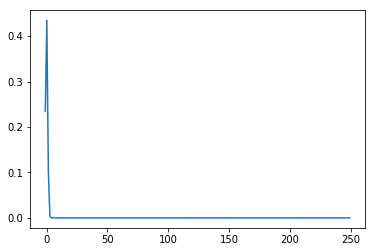

In [46]:
# distribution without winsorizing
test = frames['20040102']
density_plot(test['DlyReturn'])

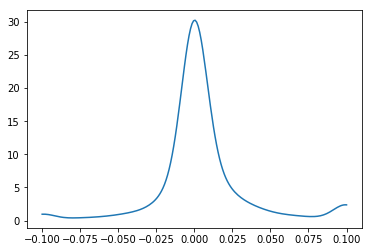

In [47]:
# distribution after winsorizing
test['DlyReturn_wins'] = wins(test['DlyReturn'],wins_lower=-0.1,wins_upper=0.1)
density_plot(test['DlyReturn_wins'])

## Quiz

Put the factor returns estimation into a function, so that this can be re-used for each day's data.

In [48]:
def estimate_factor_returns(df, wins_lower=-.25, wins_upper=0.25): 
    ## TODO: build estimation universe based on filters 
    estu = df.loc[df.IssuerMarketCap > 1e9].copy(deep=True)
  
    ## TODO: winsorize returns for fitting 
    estu['DlyReturn'] = wins(estu['DlyReturn'], wins_lower, wins_upper)
  
    ## get a list of all the factors
    all_factors = factors_from_names(list(df))
    
    ## define a 'formula' for the regression
    form = get_formula(all_factors, "DlyReturn")
    
    ## create the OLS model, passing in the formula and the estimation universe dataframe
    model = ols(formula=form, data=estu)
    
    ## return the estimated coefficients
    results = model.fit()
    return(results.params)

## Choose alpha factors

We'll choose the 1 day reversal, earnings yield, value, and sentiment factors as alpha factors.  We'll calculate the factor returns of these alpha factors to see how they performed.

In [49]:
alpha_factors = ["USFASTD_1DREVRSL", "USFASTD_EARNYILD", "USFASTD_VALUE", "USFASTD_SENTMT"]
print(alpha_factors)

['USFASTD_1DREVRSL', 'USFASTD_EARNYILD', 'USFASTD_VALUE', 'USFASTD_SENTMT']


## Quiz: estimate factor returns of alpha factors

Loop through each day, and estimate the factors returns of each factor, that date, in the `frames` dictionary.  This may take a minute or more to run per year of data used.

In [50]:
facret = {}
for date in frames:
    # TODO: store factor returns as key-value pairs in a dictionary
    facret[date] = estimate_factor_returns(frames[date])

In [51]:
type(facret['20040102'])

pandas.core.series.Series

In [52]:
facret['20040102'].head()

USFASTD_1DREVRSL    0.000058
USFASTD_AERODEF    -0.006754
USFASTD_AIRLINES    0.011158
USFASTD_ALUMSTEL    0.004400
USFASTD_APPAREL    -0.018701
dtype: float64

## put the factor returns into a dataframe

The pandas series are stored inside a dictionary.  We'll put the factor returns into a dataframe where the rows are the dates and the columns are the factor returns (one column for each factor).

First, let's get a list of dates, as Timestamp objects.  We'll use [pandas.to_datetime](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html)

In [53]:
# example of how to convert the keys of the dataframe into Timestamp objects
pd.to_datetime('20040102', format='%Y%m%d')

Timestamp('2004-01-02 00:00:00')

## Quiz

Store the timestamp objects in a list (can use a list comprehension, or for loop).

In [54]:
# TODO
dates_unsorted = [pd.to_datetime(date, format='%Y%m%d') for date in frames.keys()]

In [55]:
# sort the dates in ascending order
my_dates = sorted(dates_unsorted)

In [56]:
# We'll make an empty dataframe with the dates set as the row index.
facret_df = pd.DataFrame(index = my_dates)

In [57]:
facret_df.head()

""
2003-01-06
2003-01-07
2003-01-08
2003-01-09
2003-01-10


The rows are the dates.  The columns will be the factor returns. 

To convert from Timestamp objects back into a string, we can use [Timestamp.strftime('%Y%m%d')](https://www.programiz.com/python-programming/datetime/strftime). 

In [58]:
## example usage of Timestamp.strftime('%Y%m%d')
my_dates[0].strftime('%Y%m%d')

'20030106'

## Quiz
For each date, and for each factor return, get the value from the dictionary and put it into the dataframe.

We can use [pandas.DataFrame.at¶](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.at.html), 

```
DataFrame.at[<index_value>,<column_name>] = <some_value>
```

In [59]:
# TODO: for each date (rows), and for each factor (columns),
# store factor return in the dataframe
for dt in my_dates: 
    for alp in alpha_factors:
        facret_df.at[dt, alp] = facret[dt.strftime('%Y%m%d')][alp]

## Portfolio optimization for a single period

When we get to the project, we'll want to define the portfolio optimization within a function.  For now, let's walk through the steps we'll take in separate cells, so that we can see what's going on.

The optimization will want to know about the prior trading day's portfolio holdings, also called holdings.  The previous day's holdings will be used to estimate the size of the trades due to position changes, which in turn helps us estimate transaction costs.  We'll start with an initial holding of zero for a single stock.  The reason we'll use a single stock is that the estimation universe chosen on each day will include all stocks that have holdings on the previous day.  So we want to keep this list small when we first start out, else we'll keep many stocks that may fall below the 1 billion market cap threshold, just because they were chosen in the initialization of the backtest.

We'll want to choose a stock that is likely to satisfy the 1 billion market cap threshold on any day.  So let's choose the stock with the largest market cap.

In [60]:
# we're going to set a single barra id to have a zero portfolio holding, 
# so let's pick any barra id of the stock with the largest issuer market cap
estu.sort_values('IssuerMarketCap',ascending=False)[['Barrid','IssuerMarketCap']].head()

,Barrid,IssuerMarketCap
5000,USAJ471,2.881259e+11
50,USA0421,2.881259e+11
34,USA02P1,2.535125e+11
4109,USAFVO1,2.535125e+11
31,USA02E1,2.396864e+11


## Quiz: Intialize previous holdings dataframe

Create a new dataframe and initialize it with a dictionary, where the key is "Barrid" followed by a value that is a pandas.Series containing the barra id of the largest market cap in the stock universe.  

Also set another key value pair to "x.opt.previous" and the value is set to a pandas.Series with the value 0.

In [61]:
# TODO
# create a dataframe of previous holdings, 
# initializing a single stock (barra id) to zero portfolio holding
previous_holdings = pd.DataFrame(data = {"Barrid" : pd.Series( ["USA0001"]), 
                                         "x.opt.previous" : pd.Series(0)})

In [62]:
previous_holdings

,Barrid,x.opt.previous
0,USA0001,0


Get a single day's data to be used for the portfolio optimization.

In [63]:
dt = my_dates[0]
date = dt.strftime('%Y%m%d')
print(date)
df = frames[date]
df.head()

20030106


,Barrid,USFASTD_1DREVRSL,USFASTD_AERODEF,USFASTD_AIRLINES,USFASTD_ALUMSTEL,USFASTD_APPAREL,USFASTD_AUTO,USFASTD_BANKS,USFASTD_BETA,USFASTD_BEVTOB,...,ADTCA_30,IssuerMarketCap,Yield,TotalRisk,SpecRisk,HistBeta,PredBeta,DataDate,DlyReturn,DlyReturnDate
0,USA0001,-0.837,0.000,0.0,0.000,0.0,0.0,0.0,-2.329,0.0,...,NaN,3.441677e+10,0.292740,22.940188,16.825603,-0.000285,0.194528,20030102,0.0,20030106
1,USA0011,-0.530,0.000,0.0,0.000,0.0,0.0,0.0,-2.329,0.0,...,NaN,1.758417e+09,0.000000,35.056218,26.040331,0.000025,0.150303,20030102,0.0,20030106
2,USA0031,0.109,0.000,0.0,0.000,0.0,0.0,0.0,-2.018,0.0,...,NaN,6.256875e+10,2.350000,25.585521,18.842191,0.133644,0.364634,20030102,0.0,20030106
3,USA0062,-0.259,0.434,0.0,0.000,0.0,0.0,0.0,-2.378,0.0,...,NaN,2.046586e+10,3.125000,34.361884,30.552489,-0.021132,0.274658,20030102,0.0,20030106
4,USA0071,-0.394,0.000,0.0,0.665,0.0,0.0,0.0,-2.332,0.0,...,NaN,1.988087e+10,2.633889,22.893482,15.466688,-0.001328,0.246267,20030102,0.0,20030106


Let's add the previous holdings column to the dataframe

In [64]:
## merge previous portfolio holdings 
df = df.merge(previous_holdings, how = 'left', on = 'Barrid')

In [65]:
df.head()

,Barrid,USFASTD_1DREVRSL,USFASTD_AERODEF,USFASTD_AIRLINES,USFASTD_ALUMSTEL,USFASTD_APPAREL,USFASTD_AUTO,USFASTD_BANKS,USFASTD_BETA,USFASTD_BEVTOB,...,IssuerMarketCap,Yield,TotalRisk,SpecRisk,HistBeta,PredBeta,DataDate,DlyReturn,DlyReturnDate,x.opt.previous
0,USA0001,-0.837,0.000,0.0,0.000,0.0,0.0,0.0,-2.329,0.0,...,3.441677e+10,0.292740,22.940188,16.825603,-0.000285,0.194528,20030102,0.0,20030106,0.0
1,USA0011,-0.530,0.000,0.0,0.000,0.0,0.0,0.0,-2.329,0.0,...,1.758417e+09,0.000000,35.056218,26.040331,0.000025,0.150303,20030102,0.0,20030106,NaN
2,USA0031,0.109,0.000,0.0,0.000,0.0,0.0,0.0,-2.018,0.0,...,6.256875e+10,2.350000,25.585521,18.842191,0.133644,0.364634,20030102,0.0,20030106,NaN
3,USA0062,-0.259,0.434,0.0,0.000,0.0,0.0,0.0,-2.378,0.0,...,2.046586e+10,3.125000,34.361884,30.552489,-0.021132,0.274658,20030102,0.0,20030106,NaN
4,USA0071,-0.394,0.000,0.0,0.665,0.0,0.0,0.0,-2.332,0.0,...,1.988087e+10,2.633889,22.893482,15.466688,-0.001328,0.246267,20030102,0.0,20030106,NaN


## Clean missing and zero values.

First replace missing values with zero.

In [66]:
def na2z(x):
    return(np.nan_to_num(x))

def names_numeric_columns(df): 
    return(df.select_dtypes(include=[np.number]).columns.tolist())

def clean_nas(df):
    for x in names_numeric_columns(df): 
        df[x] = na2z(df[x])
    return(df)

In [67]:
df = clean_nas(df)

## Quiz: Clean specific risk
Barra calculates specific risk for each asset.  If the value in the data is zero, this may be due to missing data rather than the specific risk actually being zero.  So we'll set zero values to the median, to make sure our model is more realistic.

In [68]:
# TODO: if SpecRisk is zero, set it to median
df.loc[df['SpecRisk'] == 0]['SpecRisk'] = median(df['SpecRisk'])

## universe

We'll look at stocks that are 1 billion in market cap or greater.  An important point here is that we'll need to account for stocks that are already in our portfolio, even if the market cap of the stock is no longer 1 billion on the current day.

#### Quiz: think about what would happen if we had an existing position in a stock, then the market cap fell below the threshold and the stock was excluded from the stock universe.  What would happen to the position on that stock?

#### Answer
The stock would not be included in the optimization, which means it would be given a zero position.  So this effectively says to sell all holdings in the asset once it falls below the market cap threshold.  That's not what we want to do.

Modify the code to account for the prior day's positions.

In [69]:
## TODO: modify the given code to include the prior day's assets
universe = df.loc[(df['IssuerMarketCap'] >= 1e9)].copy()

In [70]:
## Solution
universe = df.loc[(df['IssuerMarketCap'] >= 1e9) | (abs(df['x.opt.previous']) > 0)].copy()

In [71]:
universe.head()

,Barrid,USFASTD_1DREVRSL,USFASTD_AERODEF,USFASTD_AIRLINES,USFASTD_ALUMSTEL,USFASTD_APPAREL,USFASTD_AUTO,USFASTD_BANKS,USFASTD_BETA,USFASTD_BEVTOB,...,IssuerMarketCap,Yield,TotalRisk,SpecRisk,HistBeta,PredBeta,DataDate,DlyReturn,DlyReturnDate,x.opt.previous
0,USA0001,-0.837,0.000,0.0,0.000,0.0,0.0,0.0,-2.329,0.0,...,3.441677e+10,0.292740,22.940188,16.825603,-0.000285,0.194528,20030102,0.0,20030106,0.0
1,USA0011,-0.530,0.000,0.0,0.000,0.0,0.0,0.0,-2.329,0.0,...,1.758417e+09,0.000000,35.056218,26.040331,0.000025,0.150303,20030102,0.0,20030106,0.0
2,USA0031,0.109,0.000,0.0,0.000,0.0,0.0,0.0,-2.018,0.0,...,6.256875e+10,2.350000,25.585521,18.842191,0.133644,0.364634,20030102,0.0,20030106,0.0
3,USA0062,-0.259,0.434,0.0,0.000,0.0,0.0,0.0,-2.378,0.0,...,2.046586e+10,3.125000,34.361884,30.552489,-0.021132,0.274658,20030102,0.0,20030106,0.0
4,USA0071,-0.394,0.000,0.0,0.665,0.0,0.0,0.0,-2.332,0.0,...,1.988087e+10,2.633889,22.893482,15.466688,-0.001328,0.246267,20030102,0.0,20030106,0.0


## Quiz: Nothing here should be allowed to look at returns when forming the portfolio.
Make this impossible by removing the Daily returns data from the dataframe.  Drop the DlyReturn field from the dataframe.

In [72]:
# TODO
universe = universe.drop(columns = 'DlyReturn')

In [73]:
## this will extract all of the factors, including the alphas 
# list(universe) gets a list of the column names of the dataframe
all_factors = factors_from_names(list(universe))

In [74]:
all_factors

['USFASTD_1DREVRSL',
 'USFASTD_AERODEF',
 'USFASTD_AIRLINES',
 'USFASTD_ALUMSTEL',
 'USFASTD_APPAREL',
 'USFASTD_AUTO',
 'USFASTD_BANKS',
 'USFASTD_BETA',
 'USFASTD_BEVTOB',
 'USFASTD_BIOLIFE',
 'USFASTD_BLDGPROD',
 'USFASTD_CHEM',
 'USFASTD_CNSTENG',
 'USFASTD_CNSTMACH',
 'USFASTD_CNSTMATL',
 'USFASTD_COMMEQP',
 'USFASTD_COMPELEC',
 'USFASTD_COMSVCS',
 'USFASTD_CONGLOM',
 'USFASTD_CONTAINR',
 'USFASTD_DISTRIB',
 'USFASTD_DIVFIN',
 'USFASTD_DIVYILD',
 'USFASTD_DWNRISK',
 'USFASTD_EARNQLTY',
 'USFASTD_EARNYILD',
 'USFASTD_ELECEQP',
 'USFASTD_ELECUTIL',
 'USFASTD_FOODPROD',
 'USFASTD_FOODRET',
 'USFASTD_GASUTIL',
 'USFASTD_GROWTH',
 'USFASTD_HLTHEQP',
 'USFASTD_HLTHSVCS',
 'USFASTD_HOMEBLDG',
 'USFASTD_HOUSEDUR',
 'USFASTD_INDMACH',
 'USFASTD_INDMOM',
 'USFASTD_INSURNCE',
 'USFASTD_INTERNET',
 'USFASTD_LEISPROD',
 'USFASTD_LEISSVCS',
 'USFASTD_LEVERAGE',
 'USFASTD_LIFEINS',
 'USFASTD_LIQUIDTY',
 'USFASTD_LTREVRSL',
 'USFASTD_MEDIA',
 'USFASTD_MGDHLTH',
 'USFASTD_MGMTQLTY',
 'USFASTD_MIDC

## Alpha factors

Just a reminder that we chose four of these factors that represent previously effective alpha factors.  Since these factors became well known over time, they were added to the Barra data set.  For the time frame that we're running the back-test, these were effective alpha factors.

In [75]:
alpha_factors #4 alpha factors

['USFASTD_1DREVRSL', 'USFASTD_EARNYILD', 'USFASTD_VALUE', 'USFASTD_SENTMT']

## Quiz: risk factors

The risk factors we'll use are all the factors that are not alpha factors.  Complete the setdiff function so that it takes a superset, a subset, and returns the difference as a set.

diff= SuperSet \ Subset

In [76]:
def setdiff(superset, subset): 
    # TODO
    s = set(subset)
    diffset = [x for x in superset if x not in s]
    return(diffset)

In [77]:
risk_factors = setdiff(all_factors, alpha_factors)

In [78]:
# 77 risk factors
len(risk_factors)

77

Save initial holdings in a variable for easier access.  We'll later use it in matrix multiplications, so let's convert this to a numpy array.  We'll also use another variable to represent the current holdings, which are to be run through the optimizer.  We'll set this to be a copy of the previous holdings.  Later the optimizer will continually update this to optimize the objective function.

In [79]:
## initial holdings (before optimization)
# optimal holding from prior day
h0 = np.asarray( universe['x.opt.previous'] )

In [80]:
h = h0.copy()

## Matrix of Risk Factor Exposures $\textbf{B}$

The dataframe contains several columns that we'll use as risk factors exposures.  Extract these and put them into a matrix.

The data, such as industry category, are already one-hot encoded, but if this were not the case, then using `patsy.dmatrices` would help, as this function extracts categories and performs the one-hot encoding.  We'll practice using this package, as you may find it useful with future data sets.  You could also store the factors in a dataframe if you prefer to avoid using patsy.dmatrices.

#### How to use patsy.dmatrices

patsy.dmatrices takes in a formula and the dataframe.  The formula tells the function which columns to take.  The formula will look something like this:  
`SpecRisk ~ 0 + USFASTD_AERODEF + USFASTD_AIRLINES + ...`  
where the variable to the left of the ~ is the "dependent variable" and the others to the right are the independent variables (as if we were preparing data to be fit to a model).

This just means that the pasty.dmatrices function will return two matrix variables, one that contains the single column for the dependent variable `outcome`, and the independent variable columns are stored in a matrix `predictors`.

The `predictors` matrix will contain the matrix of risk factors, which is what we want.  We don't actually need the `outcome` matrix; it's just created because that's the way patsy.dmatrices works.

In [81]:
# Note that we chose "SpecRisk" simply because it's not one of the USFAST factors.
# it will be discarded in the next step.
formula = get_formula(risk_factors, "SpecRisk")
formula

'SpecRisk ~ 0 + USFASTD_AERODEF + USFASTD_AIRLINES + USFASTD_ALUMSTEL + USFASTD_APPAREL + USFASTD_AUTO + USFASTD_BANKS + USFASTD_BETA + USFASTD_BEVTOB + USFASTD_BIOLIFE + USFASTD_BLDGPROD + USFASTD_CHEM + USFASTD_CNSTENG + USFASTD_CNSTMACH + USFASTD_CNSTMATL + USFASTD_COMMEQP + USFASTD_COMPELEC + USFASTD_COMSVCS + USFASTD_CONGLOM + USFASTD_CONTAINR + USFASTD_DISTRIB + USFASTD_DIVFIN + USFASTD_DIVYILD + USFASTD_DWNRISK + USFASTD_EARNQLTY + USFASTD_ELECEQP + USFASTD_ELECUTIL + USFASTD_FOODPROD + USFASTD_FOODRET + USFASTD_GASUTIL + USFASTD_GROWTH + USFASTD_HLTHEQP + USFASTD_HLTHSVCS + USFASTD_HOMEBLDG + USFASTD_HOUSEDUR + USFASTD_INDMACH + USFASTD_INDMOM + USFASTD_INSURNCE + USFASTD_INTERNET + USFASTD_LEISPROD + USFASTD_LEISSVCS + USFASTD_LEVERAGE + USFASTD_LIFEINS + USFASTD_LIQUIDTY + USFASTD_LTREVRSL + USFASTD_MEDIA + USFASTD_MGDHLTH + USFASTD_MGMTQLTY + USFASTD_MIDCAP + USFASTD_MOMENTUM + USFASTD_MULTUTIL + USFASTD_OILGSCON + USFASTD_OILGSDRL + USFASTD_OILGSEQP + USFASTD_OILGSEXP + USF

In [82]:
# the factors will be in the second returned variable (predictors)
# the outcome variable contains the SpecRisk data, which we don't actually need here
outcome, predictors = patsy.dmatrices(formula,universe)

`predictors` contains the factor exposures of each asset to each factor.

In [83]:
predictors.shape

(1756, 77)

## Factor exposure matrix $\textbf{B}$


Remember, the factor exposure matrix has the exposure of each asset to each factor.  Thee number of rows is number of assets, and number of columns is the number of factors.

In [84]:
def NROW(x):
    return(np.shape(x)[0])

def NCOL(x):
    return(np.shape(x)[1])

## Quiz

Set the factor exposure matrix and its transpose, using one of the outputs from calling patsy.dmatrices

In [85]:
## TODO: risk exposure matrix: 
B = predictors
BT = B.transpose()

k = NCOL(B) #number of factors (77)
n = NROW(B) #number of assets (2000+)

## Factor covariance matrix $\textbf{F}$

We can improve on the factor covariance matrix by reducing noise and also increasing computational efficiency.

If we have, 70 risk factors in our risk model, then the covariance matrix of factors is a 70 by 70 square matrix.  The diagonal contains the variances of each factor, while the off-diagonals contain the pairwise covariances of two different risk factors.

In general, it’s good to have a healthy suspicion of correlations and covariances, and to ask if correlation data adds information or just more noise.  One way to be conservative about the information in a covariance matrix is to shrink the covariances, or even reduce them to zero.  In other words, we could keep just the variances along the diagonal, and set the covariances in the off-diagonals to zero.

In the case where we’re using the covariance matrix in a risk factor model, there’s also some additional intuition for why we can try using just the variances, and discard the covariances.  The goal of the optimizer is to reduce the portfolio’s exposure to these risk factors.  So if the optimizer reduces the portfolio’s exposure to risk factor “one”, and also reduces its exposure to risk factor “two”, then it’s less important to know exactly how factor one varies with factor two.

You may wonder what are the benefits of throwing away the information about the covariances.  In addition to making your model more conservative, and limiting possible noise in your data, a diagonal matrix also makes matrix operations more efficient.  This theme of computational efficiency is one that you’ll come across in many use cases, including backtesting.  Backtesting is a computationally and time-intensive process, so the more efficient you can make it, the more quickly you can test your alphas, and iterate to make improvements.


## Create Factor covariance matrix $\textbf{F}$

You can try getting all covariances into the matrix.  Notice that we'll run into some issues where the covariance data doesn't exist.

One important point to remember is that we need to order the factors in the covariance matrix F so that they match up with the order of the factors in the factor exposures matrix B.

Note that covariance data is in percentage units squared, so to use decimals, so we'll rescale it to convert it to decimal.

In [86]:
## With all covariances
def colnames(X):
    if(type(X) == patsy.design_info.DesignMatrix): 
        return(X.design_info.column_names)
    if(type(X) == pandas.core.frame.DataFrame): 
        return(X.columns.tolist())
    return(None)

## extract a diagonal element from the factor covariance matrix 
def get_cov_version1(cv, factor1, factor2): 
    try:
        return(cv.loc[(cv.Factor1==factor1) & (cv.Factor2==factor2),"VarCovar"].iloc[0])
    except:
        print(f"didn't find covariance for: factor 1: {factor1} factor2: {factor2}")
        return 0

def diagonal_factor_cov_version1(date, B):
    """
    Notice that we'll use the order of column names of the factor exposure matrix
    to set the order of factors in the factor covariance matrix
    """
    cv = covariance[date]
    k = NCOL(B)
    Fm = np.zeros([k,k])
    for i in range(0,k):
        for j in range(0,k): 
            fac1 = colnames(B)[i]
            fac2 = colnames(B)[j]
            # Convert from percentage units squared to decimal
            Fm[i,j] = (0.01**2) * get_cov_version1(cv, fac1, fac2)
    return(Fm)

Here's an example where the two factors don't have covariance data for the date selected

In [87]:
cv = covariance['20031211']
cv.loc[(cv.Factor1=='USFASTD_AERODEF') & (cv.Factor2=='USFASTD_ALUMSTEL')]

,Factor1,Factor2,VarCovar,DataDate


We can see where all the factor covariances aren't found in the data.

## Which date?

Recall that there's a DataDate column and DlyReturnDate column in the dataframe.  We're going to use a date to access the covariance data.  Which date should we use?

In [88]:
df.head()

,Barrid,USFASTD_1DREVRSL,USFASTD_AERODEF,USFASTD_AIRLINES,USFASTD_ALUMSTEL,USFASTD_APPAREL,USFASTD_AUTO,USFASTD_BANKS,USFASTD_BETA,USFASTD_BEVTOB,...,IssuerMarketCap,Yield,TotalRisk,SpecRisk,HistBeta,PredBeta,DataDate,DlyReturn,DlyReturnDate,x.opt.previous
0,USA0001,-0.837,0.000,0.0,0.000,0.0,0.0,0.0,-2.329,0.0,...,3.441677e+10,0.292740,22.940188,16.825603,-0.000285,0.194528,20030102,0.0,20030106,0.0
1,USA0011,-0.530,0.000,0.0,0.000,0.0,0.0,0.0,-2.329,0.0,...,1.758417e+09,0.000000,35.056218,26.040331,0.000025,0.150303,20030102,0.0,20030106,0.0
2,USA0031,0.109,0.000,0.0,0.000,0.0,0.0,0.0,-2.018,0.0,...,6.256875e+10,2.350000,25.585521,18.842191,0.133644,0.364634,20030102,0.0,20030106,0.0
3,USA0062,-0.259,0.434,0.0,0.000,0.0,0.0,0.0,-2.378,0.0,...,2.046586e+10,3.125000,34.361884,30.552489,-0.021132,0.274658,20030102,0.0,20030106,0.0
4,USA0071,-0.394,0.000,0.0,0.665,0.0,0.0,0.0,-2.332,0.0,...,1.988087e+10,2.633889,22.893482,15.466688,-0.001328,0.246267,20030102,0.0,20030106,0.0


## Answer

Use the DataDate, because this is when the data is received, two days before the returns are realized.

## Quiz
Choose the correct date, then use the `diagonal_factor_cov_version1` to get the factor covariance matrix of that date.

In [89]:
# TODO
date = str(int(universe['DataDate'][1]))
print(date, end =" ")
F_version1 = diagonal_factor_cov_version1(date, B)

20030102 didn't find covariance for: factor 1: USFASTD_AERODEF factor2: USFASTD_ALUMSTEL
didn't find covariance for: factor 1: USFASTD_AERODEF factor2: USFASTD_BETA
didn't find covariance for: factor 1: USFASTD_AERODEF factor2: USFASTD_CHEM
didn't find covariance for: factor 1: USFASTD_AERODEF factor2: USFASTD_CNSTMATL
didn't find covariance for: factor 1: USFASTD_AERODEF factor2: USFASTD_CONTAINR
didn't find covariance for: factor 1: USFASTD_AERODEF factor2: USFASTD_DIVYILD
didn't find covariance for: factor 1: USFASTD_AERODEF factor2: USFASTD_DWNRISK
didn't find covariance for: factor 1: USFASTD_AERODEF factor2: USFASTD_EARNQLTY
didn't find covariance for: factor 1: USFASTD_AERODEF factor2: USFASTD_GROWTH
didn't find covariance for: factor 1: USFASTD_AERODEF factor2: USFASTD_INDMOM
didn't find covariance for: factor 1: USFASTD_AERODEF factor2: USFASTD_LEVERAGE
didn't find covariance for: factor 1: USFASTD_AERODEF factor2: USFASTD_LIQUIDTY
didn't find covariance for: factor 1: USFASTD

## Quiz: Create matrix of factor variances

Just use the factor variances and set the off diagonal covariances to zero.

In [90]:
def colnames(X):
    if(type(X) == patsy.design_info.DesignMatrix): 
        return(X.design_info.column_names)
    if(type(X) == pandas.core.frame.DataFrame): 
        return(X.columns.tolist())
    return(None)

## extract a diagonal element from the factor covariance matrix 
def get_var(cv, factor): 
    # TODO
    return(cv.loc[(cv.Factor1==factor) & (cv.Factor2==factor),"VarCovar"].iloc[0])


def diagonal_factor_cov(date, B):
    """
    Notice that we'll use the order of column names of the factor exposure matrix
    to set the order of factors in the factor covariance matrix
    """
    # TODO: set the variances only
    cv = covariance[date]
    k = NCOL(B)
    Fm = np.zeros([k,k])
    for j in range(0,k): 
        fac = colnames(B)[j]
        Fm[j,j] = (0.01**2) * get_var(cv, fac)
    return(Fm)

In [91]:
## factor variances 
# gets factor vars into diagonal matrix
# takes B to know column names of B; F will be multipled by B later
# F is square; so row and col names must match column names of B.
F = diagonal_factor_cov(date, B)

In [92]:
F.shape

(77, 77)

Note how the off diagonals are all set to zero.

## alpha combination

As a simple alpha combination, combine the alphas with equal weight.  In the project, you're welcome to try other ways to combine the alphas.  For example, you could calculate some metric for each factor, which indicates which factor should be given more or less weight.

## Scale factor exposures 

Note that the terms that we're calculating for the objective function will be in dollar units.  So the expected return $-\alpha^T h$ will be in dollar units.  The $h$ vector of portfolio holdings will be in dollar units.  The vector of alpha factor exposures $\alpha$ will represent the percent change expected for each stock.  Based on the ranges of values in the factor exposure data, which are mostly between -5 and +5 and centered at zero, **we'll make an assumption that a factor exposure of 1 maps to 1 basis point of daily return on that stock.**

So we'll convert the factor values into decimals: 1 factor exposure value $\rightarrow \frac{1}{10,000}$ in daily returns.  In other words, we'll rescale the alpha factors by dividing by 10,000.

This is to make the term representing the portfolio's expected return $\alpha^T h$ be scaled so that it represents dollar units.

In [93]:
alpha_factors

['USFASTD_1DREVRSL', 'USFASTD_EARNYILD', 'USFASTD_VALUE', 'USFASTD_SENTMT']

In [94]:
def model_matrix(formula, data): 
    outcome, predictors = patsy.dmatrices(formula, data)
    return(predictors)

In [95]:
## matrix of alpha factors
B_alpha = model_matrix(get_formula(alpha_factors, "SpecRisk"), data = universe)

In [96]:
B_alpha

DesignMatrix with shape (1756, 4)
  USFASTD_1DREVRSL  USFASTD_EARNYILD  USFASTD_VALUE  USFASTD_SENTMT
            -0.837             0.360          1.132          -0.294
            -0.530             1.944          3.011           0.073
             0.109            -0.020         -0.609          -0.175
            -0.259             0.328          0.361          -0.478
            -0.394            -0.116          0.311          -0.249
            -0.093             0.270         -0.757           0.095
             0.664             0.136         -0.121          -0.078
            -0.218            -1.352          2.912           2.593
            -0.614            -0.778         -0.379           0.224
            -0.517            -0.528         -0.280           0.081
             0.323            -0.123         -0.804          -0.231
             0.582            -0.768         -0.158           0.496
            -0.416            -0.114         -0.551          -0.108
             0

## Quiz

Sum across the rows, then re-scale so that the expression $\mathbf{\alpha}^T \mathbf{h}$ is in dollar units.

In [97]:
def rowSums(m): 
    # TODO
    return(np.sum(m, axis=1))

In [98]:
# TODO
scale = 1e-4
alpha_vec = scale * rowSums(B_alpha) #sum across rows (collapse 4 columns into one)

In [99]:
alpha_vec.shape

(1756,)

## Original method of calculating common risk term

Recall that the common risk term looks like this:
$\textbf{h}^T\textbf{BFB}^T\textbf{h}$

Where h is the vector of portfolio holdings, B is the factor exposure matrix, and F is the factor covariance matrix.

We'll walk through this calculation to show how it forms an N by N matrix, which is computationally expensive, and may lead to memory overflow for large values of N.

In [100]:
np.dot( np.dot( h.T, np.matmul( np.matmul(B,F),BT) ), h)

0.0

In [101]:
tmp = np.matmul(B,F)
tmp.shape

(1756, 77)

In [102]:
# this makes an N by matrix (large)
tmp = np.matmul(tmp,BT)
tmp.shape

(1756, 1756)

In [103]:
tmp = np.matmul(h.T,tmp)
tmp.shape

(1756,)

In [104]:
tmp = np.dot(tmp,h)
tmp.shape

()

In [105]:
tmp

0.0

## Efficiently calculate common risk term (avoid N by N matrix)

Calculate the portfolio risk that is attributable to the risk factors:
$\mathbf{h}^T\mathbf{BFB}^T\mathbf{h}$

Note that this can become computationally infeasible and/or slow.  Use matrix factorization and carefully choose the order of matrix multiplications to avoid creating an N by N matrix.

#### square root of a matrix.

We can find a matrix $\mathbf{B}$ that's the matrix square root of another matrix $\mathbf{A}$, which means that if we matrix multiply $\mathbf{BB}$, we'd get back to the original matrix $\mathbf{A}$.

Find $\mathbf{Q}$ such that $\mathbf{Q}^T\mathbf{Q}$ is the same as $\mathbf{BFB}^T$.  Let's let $\mathbf{G}$ denote the square root of matrix $\mathbf{F}$, so that $\mathbf{GG} = \mathbf{F}$.

Then the expression for the covariance matrix of assets, $\mathbf{BFB}^T$, can be written as $\mathbf{BGGB}^T$.  

Let's let $\mathbf{Q}=\mathbf{GB}^T$ and let $\mathbf{Q}^T=\mathbf{BG}$, which means we can rewrite $\mathbf{BGGB}^T = \mathbf{Q}^T\mathbf{Q}$, and the common risk term is $\mathbf{h}^T\mathbf{Q}^T\mathbf{Qh}$

Also, note that we don't have to calculate $\mathbf{BFB}^T$ explicitly, because the actual value we wish to calculate in the objective function will apply the holdings $\mathbf{h}$ to the covariance matrix of assets.


## Quiz: matrix square root of F

We'll call this square root matrix $\mathbf{G}$

Use [scipy.linalg.sqrtm](https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.linalg.sqrtm.html)


In [106]:
# TODO
G = scipy.linalg.sqrtm(F)

In [107]:
G.shape

(77, 77)

Double check that multiplying the square root matrix to itself returns us back to the original matrix of factor variances.

In [108]:
np.matmul(G,G) - F

array([[-6.93889390e-18,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  1.38777878e-17,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  3.46944695e-18, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

## Quiz: calculate $\textbf{Q}$ and $\textbf{Q}^T$

In [109]:
# TODO
# Q = GB'
# Q should be a short and wide matrix
Q = np.matmul(G, BT)
Q.shape

(77, 1756)

In [110]:
# TODO
# Q' = BG
# Q should be a tall and narrow matrix
QT = np.matmul(B,G)
QT.shape

(1756, 77)

In [111]:
# notice we could also use the transpose of Q to get Q'
QT - Q.transpose()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Quiz: Include portfolio holdings

So the original formula of 
$h^TBFB^Th$ became  
$h^TBGGB^Th$, where $GG = F$.  

And then, if we let $Q^T=BG$ and $Q = GB^T$:  
$h^TQ^TQh$


Let $R = Q h$ and $R^T = h^T Q^T$:  

The risk term becomes:  
$R^TR$, where $R^T=h^TQ$ and $R=Q^Th$

So an important point here is that we don't want to multiply $Q^TQ$ itself, because this creates the large N by N matrix. We want to multiply $h^TQ^T$ and $Qh$ separately, creating vectors of length k (k is number of risk factors).

In [112]:
# TODO
# R = Qh
R = np.matmul(Q, h)
R.shape

(77,)

In [113]:
# TODO
# R' = Q'h'
RT = np.matmul(h.T,QT)
RT.shape

(77,)

## Notice how we avoided creating a full N by N matrix

Also, notice that if we have Q, we can take its transpose to get $Q^T$ instead of doing the matrix multiplication.  

Similarly, if we have R, which is a vector, we notice that $R^TR$ is the same as taking the dot product.  In other words, it's squaring each element in the vector R, and adding up all the squared values.

$R^TR = \sum_{i}^{k}(r_i^2)$

## Quiz: Put it all together: calculate common risk term efficiently

In [114]:
## TODO: common risk term in term

# TODO: calculate square root of F
G = scipy.linalg.sqrtm(F)

# TODO: calculate Q
Q = np.matmul(G, BT)

# TODO: calculate R
R = np.matmul(Q, h)

# TODO: calculate common risk term
common_risk = np.sum( R ** 2)

## Specific Risk term

The portfolio's variance that is specific to each asset is found by combining the holdings with the specific variance matrix: 

$h^TSh$, where $h^T$ is a 1 by N vector, S is an N by N matrix, and h is an N by 1 vector.

Recall that S is a diagonal matrix, so all the off-diagonals are zero.  So instead of doing the matrix multiplication, we could save computation by working with the vector containing the diagonal values.

$h^TSh = \sum_i^{N}(h_i^2 \times S_i)$ because $S$ is a diagonal matrix.

In [115]:
## check the unit of measure of SpecRisk
# Notice that these are in percent; multiply by .01 to get them back to decimals.aa
universe['SpecRisk'][0:2] 

0    16.825603
1    26.040331
Name: SpecRisk, dtype: float64

## Quiz: Specific Risk term

Given specific risk (volatility), calculate specific variance.  First re-scale the specific risk data so that it's in decimal instead of percent.

In [116]:
## TODO: specific variance : rescale it and then square to get specific variance
specVar = (0.01 * universe['SpecRisk']) ** 2

# TODO: specific risk term (include holdings)
spec_risk_term = np.dot(h**2, specVar)

NameError: name 'x' is not defined

## Maximize portfolio returns

Since the alpha vector $\mathbf{\alpha}$ is supposed to be indicative of future asset returns, when we look at a portfolio of assets, the weighted sum of these alphas $\mathbf{\alpha}^T \mathbf{h}$ is predictive of the portfolio's future returns.  We want to maximize the portfolio's expected future returns, so we want to minimize the negative of portfolio's expected returns $-\mathbf{\alpha}^T \mathbf{h}$

In [ ]:
## TODO
expected_return = np.dot(x, alpha_vec)

## Linear price impact of trading

Assume transaction cost is linearly related to the trade size as a fraction of the average daily volume.  Since we won't know the actual daily volume until the day that we're executing, we want to use past data as an estimate for future daily volume.  This would be kind of noisy if we simply use the prior day's daily volume, so we'd prefer a more stable estimate like a 30 day rolling average.

A commonly used **estimate for linear market impact is that if a trade size is 1% of the ADV, this moves the price by 10 basis points (1/10,000).**

$Trade size_{i,t}$ is the fraction of your trade relative to the average dollar volume estimated for that stock, for that day. 

$Trade_{i,t}$ = dollar amount to trade = $h_{t} - h_{t-1}$, which is the new holding of the asset minus the previous holding.

$ADV_{i,t}$: (average dollar volume) is total dollar amount expected to be traded, based on a moving average of historical daily volume.

$TradeSize_{i,t} = \frac{Trade_{i,t}}{ADV_{i,t}}$: The size of the trade relative to the estimated daily volume.

$\% \Delta Price_{i,t}$ = price change due to trading, as a fraction of the original price (it's a percent change).

We'll write out the ratio: change in price divided by the trade size.

$ \frac{\% \Delta price_{i,t}}{TradeSize_{i,t}} = \frac{10 bps}{1\%}$  

$ \frac{\% \Delta price_{i,t}}{TradeSize_{i,t}} = \frac{10/10^4}{1/100}$

$ \frac{\% \Delta price_{i,t}}{TradeSize_{i,t}} = \frac{10^{-3}}{10^{-2}}$

$ \frac{\% \Delta price_{i,t}}{TradeSize_{i,t}} = 10^{-1}$

Now we'll move things around to solve for the change in price.

$\%  \Delta price_{i,t} = 10^{-1} \times TradeSize_{i,t}$

We defined TradeSize to be the Trade divided by ADV.

$\%  \Delta price_{i,t} = 10^{-1} \times \frac{Trade_{i,t}}{ADV_{i,t}}$

Note that Trade is the current position minus the prior day's position

$\%  \Delta price_{i,t} = 10^{-1} \times \frac{h_{i,t} - h_{i,t-1}}{ADV_{i,t}}$

For convenience, we'll combine the constant $10^{-1}$ and $\frac{1}{ADV_{i}}$ and call it lambda $\lambda_{i}$

$\%  \Delta price_{i,t} = \lambda_{i,t} \times (h_{i,t} - h_{i,t-1})$ where $\lambda_{i,t} = 10^{-1}\times \frac{1}{ADV_{i,t}} = \frac{1}{10 \times ADV_{i,t}}$


Note that since we're dividing by $ADV_{i,t}$, we'll want to handle cases when $ADV_{i,t}$ is missing or zero.  In those instances, we can set $ADV_{i,t}$ to a small positive number, such as 10,000, which, in practice assumes that the stock is illiquid.

Represent the market impact as $\Delta price_{i} = \lambda_{i} (h_{i,t} - h_{i,t-1})$.  $\lambda_{i}$ incorporates the $ADV_{i,t}$.  Review the lessons to see how to do this.

Note that since we're dividing by $ADV_{i,t}$, we'll want to handle cases when $ADV_{i,t}$ is missing or zero.  In those instances, we can set $ADV_{i,t}$ to a small positive number, such as 10,000, which, in practice assumes that the stock is illiquid.

## Quiz

If the ADV field is missing or zero, set it to 10,000.

In [ ]:
# TODO: if missing, set to 10000
universe.loc[np.isnan(universe['ADTCA_30']), 'ADTCA_30'] = 1.0e4 ## assume illiquid if no volume information

# TODO: if zero, set to 10000
universe.loc[universe['ADTCA_30'] == 0, 'ADTCA_30'] = 1.0e4 ## assume illiquid if no volume information


## Quiz: calculate Lambda

In [ ]:
adv = universe['ADTCA_30']
Lambda = 0.1 / adv

## Quiz: transaction cost term

Transaction cost is change in price times dollar amount traded.  For a single asset "i":

$tcost_{i,t} = (\% \Delta price_{i,t}) \times (DollarsTraded_{i,t})$

$tcost_{i,t} = (\lambda_{i,t} \times (h_{i,t} - h_{i,t-1}) ) \times (h_{i,t} - h_{i,t-1})$

Notice that we can simplify the notation so it looks like this:

$tcost_{i,t} = \lambda_{i,t} \times (h_{i,t} - h_{i,t-1})^2$

The transaction cost term to be minimized (for all assets) is:

$tcost_{t} = \sum_i^{N} \lambda_{i,t} (h_{i,t} - h_{i,t-1})^2$  
where $\lambda_{i,t} = \frac{1}{10\times ADV_{i,t}}$

For matrix notation, we'll use a capital Lambda, $\Lambda_{t}$, instead of the lowercase lambda $\lambda_{i,t}$.

$tcost_{t} = (\mathbf{h}_{t} - \mathbf{h}_{t-1})^T \mathbf{\Lambda}_t (\mathbf{h}_{t} - \mathbf{h}_{t-1})$

Note that we'll pass in a vector of holdings as a numpy array.  For practice, we'll use the h variable that is initialized to zero.

In [ ]:
# TODO
tcost = np.dot( (h - h0) ** 2, Lambda)

## objective function

Combine the common risk, idiosyncratic risk, transaction costs and expected portfolio return into the objective function.  Put this inside a function.

Objective function is:  
factor risk + idiosyncratic risk - expected portfolio return + transaction costs  
$f(\mathbf{h}) = \frac{1}{2}\kappa \mathbf{h}_t^T\mathbf{Q}^T\mathbf{Q}\mathbf{h}_t + \frac{1}{2} \kappa \mathbf{h}_t^T \mathbf{S} \mathbf{h}_t - \mathbf{\alpha}^T \mathbf{h}_t + (\mathbf{h}_{t} - \mathbf{h}_{t-1})^T \mathbf{\Lambda} (\mathbf{h}_{t} - \mathbf{h}_{t-1})$


## Risk Aversion $\kappa$

The risk aversion term is set to target a particular gross market value (GMV), or to target a desired volatility.  In our case, we tried a few values of the risk aversion term, ran the backtest, and calculated the GMV.  Ideally, a quant who is just starting out may have a targeted GMV of 50 million.  A risk aversion term of $10^{-6}$ gets the GMV to be in the tens of millions.  A higher risk aversion term would decrease the GMV, and a lower risk aversion term would increase the GMV, and also the risk.  Note that this isn't necessarily a linear mapping, so in practice, you'll try different values and check the results.

Also, in practice, you'd normally keep the risk aversion term constant, unless your fund is accepting more investor cash, or handling redemptions.  In those instances, the fund size itself changes, so the targeted GMV also changes.  Therefore, we'd adjust the risk aversion term to adjust for the desired GMV. 

Also, note that we would keep this risk aversion term constant, and not adjust it on a daily basis.  Adjusting the risk aversion term too often would result in unecessary trading that isn't informed by the alphas.

## Quiz
An important point is to think about what matrices can be multiplied independently of the vector of asset holdings, because those can be done once outside of the objective function.  The rest of the objective function that depends on the holdings vector will be evaluated inside the objective function multiple times by the optimizer, as it searches for the optimal holdings.  


For instance, 

$\mathbf{h}^T\mathbf{BFB}^T\mathbf{h}$ became  
$\mathbf{h}^T\mathbf{BGGB}^T\mathbf{h}$, where $\mathbf{GG} = \mathbf{F}$.  

And then, if we let $\mathbf{Q}^T=\mathbf{BG}$ and $\mathbf{Q} = \mathbf{GB}^T$:  
$\mathbf{h}^T\mathbf{Q}^T\mathbf{Qh}$

Let $\mathbf{R} = \mathbf{Q h}$ and $\mathbf{R}^T = \mathbf{h}^T \mathbf{Q}^T$:  

The risk term becomes:  
$\mathbf{R}^T\mathbf{R}$, where $\mathbf{R}^T=\mathbf{h}^T\mathbf{Q}$ and $\mathbf{R}=\mathbf{Q}^T\mathbf{h}$

* Can we pre-compute Q outside of the objective function?  
* Can we pre-compute R outside of the objective function?

#### Answer
Q doesn't depend on h, the holdings vector, so it can be pre-computed once outside of the objective function.

R is created using h, the holdings vector.  This should be computed each time the objective function is called, not pre-computed beforehand.

## Risk Aversion parameter

The risk aversion term is set to target a particular gross market value (GMV), or to target a desired volatility.  

The gross market value is the dollar value of the absolute value of the long and short positions.

$ GMV = \sum_i^N(|h_{i,t}|)$

When we think about what it means to take more risk when investing, taking bigger bets with more money is a way to take on more risk.  So the risk aversion term controls how much risk we take by controlling the dollar amount of our positions, which is the gross market value.

In our case, we tried a few values of the risk aversion term, ran the backtest, and calculated the GMV.  Ideally, a quant who is just starting out may have a targeted book size of 50 million.  In other words, they try to keep their GMV around 50 million.  

A risk aversion term of $10^{-6}$ gets the GMV to be in the tens of millions.  A higher risk aversion term would decrease the GMV, and a lower risk aversion term would increase the GMV, and also the risk.  Note that this isn't necessarily a linear mapping, so in practice, you'll try different values and check the results.

Also, in practice, you'd normally keep the risk aversion term constant, unless your fund is accepting more investor cash, or handling redemptions.  In those instances, the fund size itself changes, so the targeted GMV also changes.  Therefore, we'd adjust the risk aversion term to adjust for the desired GMV. 

Also, note that we would keep this risk aversion term constant, and not adjust it on a daily basis.  Adjusting the risk aversion term too often would result in unnecessary trading that isn't informed by the alphas.


In [ ]:
## Risk aversion
risk_aversion=1.0e-6

## Quiz: define objective function

Combine the common risk, idiosyncratic risk, transaction costs and expected portfolio return into the objective function.  Put this inside a function.

Objective function is:  
factor risk + idiosyncratic risk - expected portfolio return + transaction costs  
$f(\mathbf{h}) = \frac{1}{2}\kappa \mathbf{h}_t^T\mathbf{Q}^T\mathbf{Q}\mathbf{h}_t + \frac{1}{2} \kappa \mathbf{h}_t^T \mathbf{S} \mathbf{h}_t - \mathbf{\alpha}^T \mathbf{h}_t + (\mathbf{h}_{t} - \mathbf{h}_{t-1})^T \mathbf{\Lambda} (\mathbf{h}_{t} - \mathbf{h}_{t-1})$


In [ ]:
def func(h): 
    # TODO: define the objective function, where h is the vector of asset holdings
    f = 0.0
    f += 0.5 * risk_aversion * np.sum( np.matmul(Q, h) ** 2 )
    f += 0.5 * risk_aversion * np.dot(h ** 2, specVar) #since Specific Variance is diagonal, don't have to do matmul
    f -= np.dot(h, alpha_vec)
    f += np.dot( (h - h0) ** 2, Lambda) 
    return(f)

## Gradient

Before, when we used cvxpy, we didn't have to calculate the gradient, because the library did that for us.

Objective function is:  
factor risk + idiosyncratic risk - expected portfolio return + transaction costs  
$f(\mathbf{h}) = \frac{1}{2}\kappa \mathbf{h}^T\mathbf{Q}^T\mathbf{Qh} + \frac{1}{2} \kappa \mathbf{h}^T \mathbf{S h} - \mathbf{\alpha^T h} + (\mathbf{h}_{t} - \mathbf{h}_{t-1})^T \Lambda (\mathbf{h}_{t} - \mathbf{h}_{t-1})$


Let's think about the shape of the resulting gradient. The reason we're interested in calculating the derivative is so that we can tell the optimizer in which direction, and how much, it should shift the portfolio holdings in order to improve the objective function (minimize variance, minimize transaction cost, and maximize expected portfolio return).  So we want to calculate a derivative for each of the N assets (about 2000+ in our defined universe).  So the resulting gradient will be a row vector of length N.

The gradient, or derivative of the objective function, with respect to the portfolio holdings h, is:  

$f'(\mathbf{h}) = \frac{1}{2}\kappa (2\mathbf{Q}^T\mathbf{Qh}) + \frac{1}{2}\kappa (2\mathbf{Sh}) - \mathbf{\alpha} + 2(\mathbf{h}_{t} - \mathbf{h}_{t-1}) \mathbf{\Lambda}$

We can check that each of these terms is a row vector with one value for each asset (1 by N row vector)

## Quiz

Calculate the gradient of the common risk term:

$\kappa (\mathbf{Q}^T\mathbf{Qh})$

In [ ]:
# TODO: gradient of common risk term
tmp = risk_aversion * np.matmul(QT, np.matmul(Q,h))

Verify that the calculation returns one value for each asset in the stock universe (about 2000+ )

In [ ]:
tmp.shape

## Quiz

Calculate gradient of idiosyncratic risk term

$\kappa (\mathbf{Sh})$

In [ ]:
# TODO: idiosyncratic risk gradient
tmp = risk_aversion * specVar * h

In [ ]:
tmp.shape

## Quiz

Calculate the gradient of the expected return

$- \mathbf{\alpha} $

In [ ]:
# TODO: expected return gradient
tmp = -alpha_vec

In [ ]:
tmp.shape

## Quiz

Calculate the gradient of the transaction cost.

$ 2(\mathbf{h}_{t} - \mathbf{h}_{t-1}) \mathbf{\Lambda}$

In [ ]:
# transaction cost
tmp = 2 * (h - h0 ) * Lambda

In [ ]:
tmp.shape

## Quiz: Define gradient function

Put this all together to define the gradient function.  The optimizer will use this to make small adjustments to the portfolio holdings.

#### gradient (slightly cleaned up)

We'll simplify the expression a bit by pulling the common $\kappa$ out of the common risk and specific risk.  Also, the 1/2 and 2 cancel for both risk terms.

$f'(\mathbf{h}) = \frac{1}{2}\kappa (2\mathbf{Q}^T\mathbf{Qh}) + \frac{1}{2}\kappa (2\mathbf{h}^T\mathbf{S}) - \mathbf{\alpha} + 2(\mathbf{h}_{t} - \mathbf{h}_{t-1})\cdot \Lambda$

becomes

$f'(\mathbf{h}) = \kappa (\mathbf{Q}^T\mathbf{Qh} + \mathbf{Sh}) - \mathbf{\alpha} + 2(\mathbf{h}_{t} - \mathbf{h}_{t-1}) \mathbf{\Lambda}$

In [ ]:
# Solution
def grad(x):
    # TODO
    g = risk_aversion * (np.matmul(QT, np.matmul(Q,h)) + (specVar * h) ) 
        - alpha_vec 
        + 2 * (h-h0) * Lambda
    return(np.asarray(g))

## Optimizer

Choose an optimizer.  You can read about these optimizers:

* L-BFGS  
* Powell
* Nelder-Mead
* Conjugate Gradient

In this [page about math optimization](http://scipy-lectures.org/advanced/mathematical_optimization/)

Also read the [scipy.optimize documentation](https://docs.scipy.org/doc/scipy/reference/optimize.html)

Pass in the objective function, prior day's portfolio holdings, and the gradient.

In [ ]:
# TODO
optimizer_result = scipy.optimize.fmin_l_bfgs_b(func, h0, fprime=grad)

h1 = optimizer_result[0]

In [ ]:
opt_portfolio = pd.DataFrame(data = {"Barrid" : universe['Barrid'], "h.opt" : h1})

In [ ]:
opt_portfolio.head()

## risk exposures
factor exposures times the portfolio holdings for each asset, gives the portfolio's exposure to the factors (portfolio's risk exposure).

$\mathbf{B}^T\mathbf{h}$

In [ ]:
# TODO: risk exposures
risk_exposures = np.matmul(B.T, h1)

# put this into a pandas series
pd.Series(risk_exposures, index = colnames(B))

## Quiz: alpha exposures

The portfolio's exposures to the alpha factors is equal to the matrix of alpha exposures times the portfolio holdings.  We'll use the holdings returned by the optimizer.

$\textbf{B}_{\alpha}^T\mathbf{h}$

In [ ]:
# Solution: portfolio's alpha exposure
alpha_exposures = np.matmul(B_alpha.transpose(), h1)

# put into a pandas series
pd.Series(alpha_exposures, index = colnames(B_alpha))

## Hints for the project

You'll be putting this optimization code into functions so that you can call the optimizer in a loop, as the backtester walks through each day in the data.